Cursist: Sam Deleu

# Opdracht Autoencoders


Autoencoders zijn neurale netwerken die getraind worden om hun eigen input te reconstrueren. De toepassingen die mogelijk gemaakt worden door autoencoders variëren van compressie, denoising, reconstructie van afbeeldingen, unsupervised pre-training tot en met one-class classificatie, resolution upscaling, recommendation systems, anomaly detection en image segmentation.

Deze opdracht bestaat uit 3 deelopdrachten:
1. Anomaly detection
2. Denoising 
3. Image segmentation

# Setup

## Imports

In [43]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_squared_error,
)
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from skimage.metrics import structural_similarity
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, BatchNormalization,concatenate,
    Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Reshape, Resizing,
)
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

# Some defaults for matplotlib
LARGE = 12
MEDIUM = 10
SMALL = 6
plt.tight_layout()
plt.rcParams.update({
    'legend.fontsize': SMALL,
    'figure.figsize': (5, 3),
    'axes.labelsize': SMALL,
    'axes.titlesize': SMALL,
    'xtick.labelsize': SMALL,
    'ytick.labelsize': SMALL,
    'figure.titlesize': LARGE
})
# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


<Figure size 500x300 with 0 Axes>

## Helper Functions

In [2]:
# Display Helpers
def display_title(title, value=None):
    if value is None:
        cprint(title, "black", "on_cyan")
    else:
        print(colored(title, "blue"))
        print(value)

def display_value(title, value):
    print(f"{colored(title, "blue")}: {value}")

# 1. Fraude detectie

Een anomalie is een datapunt dat qua statistische eigenschappen sterk afwijkt van de meerderheid van de datapunten. Zo kunnen ook frauduleuze banktransacties aanzien worden als anomalieën.
Een van de grootste uitdagingen bij het detecteren van anomaliën is de ongebalanceerdheid van de data. Deze anomalieën komen per definitie vrij uitzonderlijk voor. 

Een mogelijke benadering voor het detecteren van anomalieën is leren van de distributie van normale datapunten, in dit geval normale banktransacties. Vervolgens kan je nieuwe datapunten classificeren als anomalieën wanneer ze volgens de geleerde distributie heel onwaarschijnlijk zijn.

Autoencoders kunnen de distributie van de normale datapunten leren door deze normale datapunten te leren reconstrueren. De getrainde autoencoder zal vervolgens moeite hebben om anamalieën te reconstrueren met als resultaat een hoge reconstructie-error, bijvoorbeeld de MSE = Mean Squared Error. https://keras.io/losses/

𝑀𝑆𝐸=𝑖𝑛∑𝑛𝑖=1(𝑌−𝑌̂ )2

Een transactie kan dus als frauduleus verondersteld worden wanneer de reconstructie-error boven een zekere threshold uitsteekt. 
Men spreekt van een one-class classifier.


Gegeven is een dataset met banktransacties. Bepaalde features zijn geanonimiseerd (aangeduid met V). Andere features duiden het bedrag en het tijdstip aan. Alle transacties kregen het label 1 (frauduleus) of 0 (normale transactie).



Doorloop de volgende stappen:

- Controleer in welke mate de dataset gebalanceerd is.

- Preprocessing.

- Opbouwen van een training set en test set.

- Train de autoencoder.

- Gebruik de classificatie-error om een transactie te classificeren als normaal of frauduleus.

- Test de autoencoder op de test set.

- Voer hyperparameter tuning uit op het neuraal netwerk, maar zoek ook een gepaste waarde voor de threshold op de reconstructie error. 

- Beantwoord de vragen.


In [ ]:
# Inlezen van de dataset

creditcard_input_dataset = pd.read_csv('creditcard.csv')
creditcard_input_dataset.head()


In [ ]:
creditcard_input_dataset.describe().transpose().sort_values("std", ascending=False)

## Analyse van de dataset

- Controleer in welke mate de dataset ongebalanceerd is. Maak daarvoor een histogram van de klasselabels. Een geschikte plot is de seaborn countplot (https://seaborn.pydata.org/generated/seaborn.countplot.html).


In [ ]:
# Analyse van de dataset
plt.figure(figsize=(6, 4))
x = creditcard_input_dataset["Class"].value_counts()
display_title("Verdeling", x)
sns.countplot(creditcard_input_dataset, x="Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [ ]:
# Kijken of er null-values zijn
creditcard_input_dataset.info()
creditcard_input_dataset.info()

In [ ]:
# Lineaire correlatie tussen de features - heatmap
# Omdat de waarden reeds vanuit een PCA komen is het niet waarschijnlijk dat er verbanden zullen zijn.
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(
    creditcard_input_dataset.corr(method='pearson'),
    # mask=mask,
    cmap=sns.diverging_palette(220, 20, s=100.0, sep=10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"fontsize":8}
)
plt.suptitle('Correlatie Heatmap: full dataset')
plt.show()

In [ ]:
# Lineaire correlatie tussen de features - heatmap
# 
# Selectie van eventueel te verwijderen features
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(
    creditcard_input_dataset[["V2", "V6", "V7", "V21", "Class", "Amount"]].corr(method='pearson'),
    # mask=mask,
    cmap=sns.diverging_palette(220, 20, s=100.0, sep=10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
    annot_kws={"fontsize":8}
)
plt.suptitle('Correlatie Heatmap: partial dataset')
plt.show()

In [ ]:
# creditcard_dataset.plot.hist(bins=20)
creditcard_input_dataset.hist(bins=50, xlabelsize=8, ylabelsize=8, layout=(8, 4), figsize=(10, 10), color="r")

## Preprocessing

- Kuis de dataset op. Verwijder de irrelevante features.
- Splits op in een trainig set en test set. Zorg ervoor dat je een gebalanceerde test set bekomt. 

In [ ]:
# Verwijderen van de "Time" variable
# Deze geeft een tijdslijn aan tussen transacties en zal eerder een negatieve invloed hebben op het reconstrueren van transactie
# Een alternatief zou kunnen zijn om de tijd te herberekenen op een "uur van de dag"
creditcard_dataset = creditcard_input_dataset.drop(["Time"], axis=1)
display(creditcard_dataset.columns)

In [ ]:
# Normalisatie van de data
# Alle waarden worden genormaliseerd om waarden tussen 0 en 1 te krijgen.
# We kunnen de Class hierin meenemen omdat die toch 0 of 1 is
scaler = MinMaxScaler().fit(creditcard_dataset)
creditcard_scaled_input_n = scaler.transform(creditcard_dataset)
creditcard_scaled_input_df = pd.DataFrame(creditcard_scaled_input_n, columns = creditcard_dataset.columns)
creditcard_scaled_input_df.hist(bins=50, xlabelsize=8, ylabelsize=8, layout=(8, 4), figsize=(10, 10), color="r")

display_title("Unique values for 'Class' before", creditcard_scaled_input_df["Class"].value_counts())
# display_value("Unique values for 'Class'", creditcard_scaled_input_df["Class"].unique(), creditcard_scaled_input_df["Class"].value_counts())
# We zetten de "Class" terug in het net
creditcard_scaled_input_df["Class"] = (creditcard_scaled_input_df["Class"] >= 0.7).astype(int)
display_title("Unique values for 'Class' after", creditcard_scaled_input_df["Class"].value_counts())


In [ ]:
# Creeer een train en een test-set
GOOD_transactions = creditcard_scaled_input_df[creditcard_scaled_input_df["Class"] == 0]
FRAUD_transactions = creditcard_scaled_input_df[creditcard_scaled_input_df["Class"] == 1]
display_value("creditcard_scaled_input_df.shape", creditcard_scaled_input_df.shape)
display_value("GOOD_transactions.shape", GOOD_transactions.shape)
display_value("FRAUD_transactions.shape", FRAUD_transactions.shape)

# Hierbij neem is een sample van de normale transacties die even groot is als een veelvoud van de frauduleuze transacties.
REPEAT_FRAUD_SET = 2

test_GOOD_transactions = GOOD_transactions.sample(REPEAT_FRAUD_SET * FRAUD_transactions.shape[0], random_state=42)
train_GOOD_transactions = GOOD_transactions.drop(test_GOOD_transactions.index)
display_value("test_GOOD_transactions.shape", test_GOOD_transactions.shape)
display_value("train_GOOD_transactions.shape", train_GOOD_transactions.shape)

test_FRAUD_transactions = pd.concat([FRAUD_transactions] * REPEAT_FRAUD_SET, axis=0, ignore_index=True)
test_transactions = pd.concat([test_GOOD_transactions, test_FRAUD_transactions], axis=0, ignore_index=True)
display_value("test_transactions.shape", test_transactions.shape)

# Remove the "Class" feature from the inputs
X_train_transactions = train_GOOD_transactions.drop("Class", axis=1)
y_train_transactions = train_GOOD_transactions["Class"]
display(X_train_transactions.head())
display(y_train_transactions.head().values)

X_test_transactions = test_transactions.drop("Class", axis=1)
y_test_transactions = test_transactions["Class"]
display(X_test_transactions.tail())
display(y_test_transactions.tail().values)

In [ ]:
creditcard_scaled_input_df.iloc[[43428]]

In [ ]:
# Normalisatie van de data
X_good_transactions = creditcard_scaled_input_df[creditcard_scaled_input_df["Class"] == 0]
X_fraud_transaction = creditcard_scaled_input_df[creditcard_scaled_input_df["Class"] == 1]
display(creditcard_scaled_input_df.shape, creditcard_scaled_input_df.shape[1])
display(X_good_transactions.shape)
display(X_fraud_transaction.shape)



In [ ]:
X_fraud_transaction.hist(bins=50, xlabelsize=8, ylabelsize=8, layout=(8, 4), figsize=(10, 10), color="r")

## Ontwerpen, trainen en hyperparameter tuning v.d. autoencoder

- Ontwerp en train een autoencoder. Gebruik de MSE (Mean Squared Error) loss function. Kies zelf de grootte van het neurale netwerk. Deze kan je later bij de hyperparametertuning nog aanpassen.
- Kies een threshold voor de MSE waarmee je beslist of een transactie al dan niet frauduleus is.
- Gebruik de test set om de autoencoder te evalueren. Gebruik hiervoor de accuraatheid, confusion matrix, recall, precision, f1-score en de ROC.
- Voer hyperparameter tuning uit om de performantie te verhogen. Zoek de optimale MSE threshold. Visualeer welke punten boven de threshold liggen en welke eronder. Gebruik kleur om de verschillende klasses aan te duiden.
- Stel dat de bank zoveel mogelijk false-negatives (frauduleuze transacties die als normaal werden geclassificeerd) wil vermijden. Welke aanpassingen zou je daarvoor kunnen doen? Test deze.

In [ ]:
### Ontwerp en training van de autoencoder

# Input Layer
INPUT_LAYER_SIZE = X_train_transactions.shape[1]
CODE_LAYER_SIZE = 4    # 1, 2, 4, 6, 8 geprobeerd voor undercomplete
                       # 20, 100, 500 geprobeerd voor overcomplete
input_layer = Input(shape =(INPUT_LAYER_SIZE,)) 
code_layer = Input(shape=(CODE_LAYER_SIZE,))

# 1. Het Encoder gedeelte (functional)  (met regularisatie)
def encoder_net_1(input_x):
    encoder_l1 = Dense(16, activation ='relu', 
                       activity_regularizer = regularizers.l1(10e-5))(input_x) 
    encoder_l2 = Dense(8, activation ='relu', 
                       activity_regularizer = regularizers.l1(10e-5))(encoder_l1) 
    encoded = Dense(CODE_LAYER_SIZE, activation ='relu')(encoder_l2) 
    return encoded

# Het decoder gedeelte (met regularisatie)
def decoder_net_1(encoded_x):
    decoder_l1 = Dense(8, activation ='relu', 
                       activity_regularizer = regularizers.l1(10e-5))(encoded_x) 
    decoder_l2 = Dense(16, activation ='relu', 
                       activity_regularizer = regularizers.l1(10e-5))(decoder_l1) 
    decoded = Dense(INPUT_LAYER_SIZE, activation='sigmoid')(decoder_l2)
    return decoded

# 2. Zonder regularisatie
def encoder_net_2(input_x):
    encoder_l1 = Dense(16, activation ='relu')(input_x) 
    encoder_l2 = Dense(8, activation ='relu')(encoder_l1) 
    encoded = Dense(CODE_LAYER_SIZE, activation ='relu')(encoder_l2) 
    return encoded

def decoder_net_2(encoded_x):
    decoder_l1 = Dense(8, activation ='relu')(encoded_x) 
    decoder_l2 = Dense(16, activation ='relu')(decoder_l1) 
    decoded = Dense(INPUT_LAYER_SIZE, activation='sigmoid')(decoder_l2)
    return decoded

encoder = Model(inputs=input_layer, outputs=encoder_net_1(input_layer))
encoder.summary(expand_nested=True, show_trainable=True)
decoder = Model(inputs=code_layer, outputs=decoder_net_1(code_layer))
decoder.summary(expand_nested=True, show_trainable=True)

total_fraud_autoencoder = Model(inputs=input_layer, outputs=decoder(encoder(input_layer)))
total_fraud_autoencoder.summary(expand_nested=True, show_trainable=True)

# total_fraud_autoencoder.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.RootMeanSquaredError(name="MSE")],
# )

# total_fraud_autoencoder.compile(
#     optimizer="adam",
#     loss="mean_squared_error",
#     metrics=[keras.metrics.RootMeanSquaredError(name="MSE")],
# )

# total_fraud_autoencoder.compile(
#     optimizer="adam",
#     loss="categorical_crossentropy",
#     metrics=[
#         keras.metrics.RootMeanSquaredError(name="MSE"),
#         keras.metrics.CategoricalCrossentropy(name="categorical_crossentropy")
#     ],
# )

total_fraud_autoencoder.compile(
    optimizer='adam',
    loss="mean_squared_error",
    metrics=[
        keras.metrics.RootMeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
        keras.metrics.CategoricalCrossentropy(name="Categorical_Crossentropy"),
    ],
)



In [ ]:
# Trainen van de autoencoder for normal transactions
EPOCHS = 500

early_stop = EarlyStopping(
    monitor="loss",           # metric to monitor
    patience=3,               # stop when no improvement after 10 consecutive epochs
    mode="min",               # stop when metric stops decreasing
    restore_best_weights=True,
    verbose=True,             # display the actions taken
)
history = total_fraud_autoencoder.fit(
    X_train_transactions, X_train_transactions,
    epochs=EPOCHS,
    batch_size=256,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.2
)

In [ ]:
len(history.epoch)

In [ ]:
# Plot het verloop van de metrics gedurende de training
history_df = pd.DataFrame(history.history)[["MSE", "val_MSE", "loss", "val_loss", "Binary_Crossentropy", "val_Binary_Crossentropy"]]
history_df.plot(
    kind="line",
    figsize=(8, 5),
    xlim=[0, len(history.epoch)+2], grid=True,
    xlabel="Epoch",
    # style=["r--", "g--", "b--", "y--"])
    style={
        "MSE": "r-", "val_MSE": "r--",
        "loss": "b-", "val_loss": "b--",
        "Binary_Crossentropy": "y-", "val_Binary_Crossentropy": "y--+",
    }
)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Plot het verloop van de metrics gedurende de training
# Dit brengt niets bij en diende alleen ter illustratie van het feit dat categorical crossentropy geen zin heeft
history_df = pd.DataFrame(history.history)[["Categorical_Crossentropy", "val_Categorical_Crossentropy"]]
history_df.plot(
    kind="line",
    figsize=(8, 5),
    xlim=[0, len(history.epoch)+2], grid=True,
    xlabel="Epoch",
    # style=["r--", "g--", "b--", "y--"])
    style={
        "MSE": "r-", "val_MSE": "r--",
        "loss": "b-", "val_loss": "b--",
        "Binary_Crossentropy": "y-", "val_Binary_Crossentropy": "y--+",
        "Categorical_Crossentropy": "g-", "val_Categorical_Crossentropy": "g--+"
    }
)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Testen van de autoencoder
SAMPLE_SIZE = 2
# 
display_title("Resultaten op 1 goede transactie")
selected_good_transaction = X_train_transactions[:SAMPLE_SIZE]
display(type(selected_good_transaction))
display(selected_good_transaction)
display(selected_good_transaction.values)
code_good = encoder.predict(selected_good_transaction)
display_value("Code layer output shape", code_good.shape)
display_value(f"Good Transactions codes ({type(code_good)})", f"\n{code_good}")
reconstructed_good = decoder.predict(code_good)
display(pd.DataFrame(reconstructed_good, columns = selected_good_transaction.columns))

# De reconstruction-error (MSE) voor de goede transactie
mse_good = np.mean(np.power(selected_good_transaction.values - reconstructed_good, 2), axis=1)
display_value("MSE (good entry)", mse_good)
# sk_mse_good = metrics.mean_squared_error(selected_good_transaction.values, reconstructed_good, multioutput="raw_values")
# display_value("sklearn.MSE (good entry)", sk_mse_good)

display_title("Resultaten op 1 frauduleuze transactie")
selected_fraud_transaction = test_FRAUD_transactions[:SAMPLE_SIZE].drop("Class", axis=1)
display(type(selected_fraud_transaction))
display(selected_fraud_transaction)
display(selected_fraud_transaction.values)
code_fraud = encoder.predict(selected_fraud_transaction)
display_value("Code layer output shape", code_fraud.shape)
display_value(f"Fraud Transactions codes ({type(code_fraud)})", f"\n{code_fraud}")
reconstructed_fraud = decoder.predict(code_fraud)
display(pd.DataFrame(reconstructed_fraud, columns = selected_fraud_transaction.columns))

# De reconstruction-error (MSE) voor de goede transactie
mse_fraud = np.mean(np.power(selected_fraud_transaction.values - reconstructed_fraud, 2), axis=1)
display_value("MSE (fraud entry)", mse_fraud)
# sk_mse_fraud = metrics.mean_squared_error(selected_fraud_transaction.values, reconstructed_fraud, multioutput="raw_values")
# display_value("sklearn.MSE (fraud entry)", sk_mse_fraud)


In [ ]:
# Metrics op training set
# Reconstruction error (Mean Squared Error)
display_title("Evaluation TRAINING set")
reconstructed_train_transactions = total_fraud_autoencoder.predict(X_train_transactions)
# display(type(reconstructed_train_transactions))
reconstruction_error_training = np.mean(np.power(X_train_transactions.values - reconstructed_train_transactions, 2), axis=1)
display_value("MSE Training Set", reconstruction_error_training)
display_value("Laagste MSE op training", np.min(reconstruction_error_training))
display_value("Hoogste MSE op training", np.max(reconstruction_error_training))

# Kies een waarde zodat de meeste goede goed geklasseerd zijn
threshold_train = np.percentile(reconstruction_error_training, 95) 
display_value("threshold_train", threshold_train)

y_train_predict = [1 if err > threshold_train else 0 for err in reconstruction_error_training]
display_title("classification report", classification_report(y_train_transactions, y_train_predict, zero_division=1.0))
display_title("confusion matrix", confusion_matrix(y_train_transactions, y_train_predict))
display_value("Accuracy score", (accuracy_score(y_train_transactions, y_train_predict) * 100))
display("    p0 p1")
display("a0: TN FP")
display("a1: FN TP")

display_value("MSE Threshold", threshold_train)
pd.DataFrame(reconstruction_error_training).hist(bins=3)


In [ ]:
# Metrics op test set
# Reconstruction error (Mean Squared Error)
display_title("Evaluation TEST set")
display_value("CODE_LAYER neurons", CODE_LAYER_SIZE)
reconstructed_test_transactions = total_fraud_autoencoder.predict(X_test_transactions)
# display(type(reconstructed_test_transactions))
reconstruction_error_test = np.mean(np.power(X_test_transactions.values - reconstructed_test_transactions, 2), axis=1)
display_value("MSE Test Set", reconstruction_error_test)
display_value("Laagste MSE op test", np.min(reconstruction_error_test))
display_value("Hoogste MSE op test", np.max(reconstruction_error_test))

# Bepaal de classificatie aan de hand van de voorgaande threshold
y_test_predict = [1 if err > threshold_train else 0 for err in reconstruction_error_test]
display_title("classification report", classification_report(y_test_transactions, y_test_predict, zero_division="warn"))
display_title("confusion matrix", confusion_matrix(y_test_transactions, y_test_predict))
display_value("Accuracy score", (accuracy_score(y_test_transactions, y_test_predict) * 100))
display("    p0 p1")
display("a0: TN FP")
display("a1: FN TP")

display_value("MSE Threshold", threshold_train)

In [ ]:
threshold = np.percentile(reconstruction_error, 15)
display(threshold)
y_pred = [1 if e > threshold else 0 for e in reconstruction_error]
display(sum(y_pred))

In [ ]:
# Hyperparameter tuning. Zoek naar de optimale waarde voor de MSE-threshold


In [ ]:
# Vermijden van false negatives.


## Beantwoord de onderstaande vragen
ANTWOORDEN:

-  Welk type autoencoder is het meest geschikt (undercomplete, overcomplete, convolutional, ...)? Waarom?

   Het lijkt erop dat een undercomplete (met in dit geval 4 neuronen in de code layer de betere optie is. Het lijkt erop dat minder neuronen trachten een soort globaal patroon zoeken, terwijl een teveel aan neuronen eerder naar verbanden (interpoleerbaar) zoekt tussen de verschillende features. Ik denk dat daardoor bij undercomplete een soort "globale eigenschap" wordt gevonden die eigen is aan een goede transactie en die minder voorkomt in frauduleuze transacties.

- Zou het zinvol zijn om de categorical cross-entropy te gebruiken als loss functie?

  Gezien het feit dat categorical cross-entropy in samenspel met softmax probeert een waarde te genereren die afhangt van alle features druist dit in tegen het idee dat men een zo exact mogelijke replica van de input wil hebben. Men ziet in de grafiek dat deze verspringt zonder te convergeren naar lagere waarden.

- Plot een histogram van de MSE waarden op de training set. Hoe zijn deze verdeeld? Kan je hieruit een schatting maken van waar de threshold zal komen te liggen?

  Op de plot van de MSE waarden op de training set zien we een grote groep zeer lage waarden van MSE met een aantal uitschieters. Daarom heb ik geopteerd om met percentiles te werken om een threshold te krijgen die zoveel mogelijk goede transacties omvat. 

## --> Conclusies

### Preprocessing
- dataset is heel duidelijk niet gebalanceerd

- geen noemenswaardige correlaties tussen verschillende features (eventueel V4 en Amount: 0.4), waarschijnlijk omdat de data reeds het product is van een PCA

- de Time variable heeft volgens mij geen significante meerwaarde als we een autoencoder willen gebruiken voor de classificatie.
  Deze geeft een tijdslijn aan tussen transacties en zal eerder een negatieve invloed hebben op het reconstrueren van een transactie
  Een alternatief zou kunnen zijn om de tijd te herberekenen op een "uur van de dag". Hierdoor zou de reconstructie toch rekening kunnen houden met de tijd, maar niet met de sequentie in tijd.

- data bevat geen null values en kan volledig worden gebruikt

### Train
- De training set bevat alleen "goede" transacties.
  De bedoeling is een zo goed mogelijke reconstructie van goede transacties te kunnen maken.
  Als vervolgens een "frauduleuze" transactie wordt aangeboden, wordt verwacht dat de reconstructie slecht of liefst zeer slecht is zodat die in het oog springt.

- Als loss functie werd geëxperimenteerd met "mean-squared-error" en "binary-crossentropy".
  Ter illustratie van de bovenstaande vraag werd de categorical-crossentropy ook even geprobeerd en uitgezet in grafiek.

- Een bedenking die ik echter niet verder heb uitgewerkt: kan er iets worden gedaan met de kennis die men heeft van de frauduleuze transacties?
  Hiermee bedoel ik de latente waarden te berekenen van de reconstructie van frauduleuze transacties en dan een combinatie van die kennis met deze van de goede transacties te gebruiken in de predictie.
 
### Test
- De test set bevat alle frauduleuze transacties + een even grote sample van de "goede" transacties.
  Door de test-set te balanceren denk ik dat de metrieken om het model te evalueren beter te interpreteren zijn.
   
- Deze sample is uit de training set gehaald en worden niet gebruikt tijdens training
- De grootte van de testset wordt bepaald door 1 of meerdere keren de frauduleuze transacties te gebruiken (de training set wordt hierdood kleiner)

- Om de classificatie uit te voeren wordt terug gekeken naar de MSE

### Evaluatie
- De undercomplete AE met 4 neurons in de code layer en  zonder regularisatie blijkt het best te werken als men snelheid erbij neemt


### Enkele resultaten van runs
#### Undercomplete Autoencoder without Regularisation

```
Epochs: 85

Evaluation TRAINING set
CODE_LAYER neurons: 4

8855/8855 ━━━━━━━━━━━━━━━━━━━━ 8s 854us/step
MSE Training Set: [0.00067703 0.00065632 0.00281367 ... 0.00062344 0.00351914 0.00041329]
Laagste MSE op training: 8.635496586405845e-05
Hoogste MSE op training: 0.21066324832145344
threshold_train: 0.0026070588028623484
classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    283331
           1       0.00      1.00      0.00         0

    accuracy                           0.95    283331
   macro avg       0.50      0.97      0.49    283331
weighted avg       1.00      0.95      0.97    283331

confusion matrix
[[269164  14167]
 [     0      0]]
Accuracy score: 94.99984117516262
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0026070588028623484
```

------------------------------------------------------------------------------

```
Evaluation TEST set
CODE_LAYER neurons: 4

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE Test Set: [0.00051928 0.00047291 0.00179359 ... 0.00284759 0.00596696 0.00087439]
Laagste MSE op test: 0.00010933892359824186
Hoogste MSE op test: 0.08298927929209654
classification report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       984
           1       0.96      0.87      0.92       984

    accuracy                           0.92      1968
   macro avg       0.92      0.92      0.92      1968
weighted avg       0.92      0.92      0.92      1968

confusion matrix
[[951  33]
 [126 858]]
Accuracy score: 91.92073170731707
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0026070588028623484
```

==============================================================================

#### Undercomplete Autoencoder with L1 Regularisation

```
Epochs: 32

Evaluation TRAINING set
CODE_LAYER neurons: 4
8855/8855 ━━━━━━━━━━━━━━━━━━━━ 9s 912us/step
MSE Training Set: [0.00095919 0.00062705 0.00311123 ... 0.00098528 0.00391642 0.00093597]
Laagste MSE op training: 0.0002399110415845007
Hoogste MSE op training: 0.26965057099146383
threshold_train: 0.0035181321353590983
classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    283331
           1       0.00      1.00      0.00         0

    accuracy                           0.95    283331
   macro avg       0.50      0.97      0.49    283331
weighted avg       1.00      0.95      0.97    283331

confusion matrix
[[269164  14167]
 [     0      0]]
Accuracy score: 94.99984117516262
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0035181321353590983
```

------------------------------------------------------------------------------

```
Evaluation TEST set
CODE_LAYER neurons: 4

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MSE Test Set: [0.00057391 0.00061873 0.00218368 ... 0.00304568 0.00632093 0.00111598]
Laagste MSE op test: 0.00031542728071624014
Hoogste MSE op test: 0.08413368495926093
classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       984
           1       0.95      0.85      0.90       984

    accuracy                           0.90      1968
   macro avg       0.91      0.90      0.90      1968
weighted avg       0.91      0.90      0.90      1968

confusion matrix
[[942  42]
 [150 834]]
Accuracy score: 90.2439024390244
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0035181321353590983
```

==============================================================================
#### Undercomplete Autoencoder without Regularisation bigger code layer

```
Epochs: 100+

Evaluation TRAINING set
CODE_LAYER neurons: 6

8855/8855 ━━━━━━━━━━━━━━━━━━━━ 8s 835us/step
MSE Training Set: [0.0002808  0.0003062  0.0010412  ... 0.00047923 0.0008016  0.00031004]
Laagste MSE op training: 4.146281153963198e-05
Hoogste MSE op training: 0.1949026639163019
threshold_train: 0.0016981010640722827
classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    283331
           1       0.00      1.00      0.00         0

    accuracy                           0.95    283331
   macro avg       0.50      0.97      0.49    283331
weighted avg       1.00      0.95      0.97    283331

confusion matrix
[[269164  14167]
 [     0      0]]
Accuracy score: 94.99984117516262
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0016981010640722827
```

------------------------------------------------------------------------------

```
Evaluation TEST set
CODE_LAYER neurons: 6

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE Test Set: [0.00026625 0.00035952 0.00121059 ... 0.00299825 0.00615299 0.00063766]
Laagste MSE op test: 8.629190568271519e-05
Hoogste MSE op test: 0.0789094281486494
classification report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       984
           1       0.95      0.88      0.91       984

    accuracy                           0.92      1968
   macro avg       0.92      0.92      0.92      1968
weighted avg       0.92      0.92      0.92      1968

confusion matrix
[[935  49]
 [116 868]]
Accuracy score: 91.61585365853658
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0016981010640722827
```

==============================================================================

#### Overcomplete Autoencoder with Regularisation

```
Epochs: 26

MSE Training Set: [0.0009541  0.0006321  0.0030989  ... 0.00099422 0.00390812 0.00092706]
Laagste MSE op training: 0.00023333266776852734
Hoogste MSE op training: 0.26959156306089915
threshold_train: 0.0035130688616099625
classification report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    283331
           1       0.00      1.00      0.00         0

    accuracy                           0.95    283331
   macro avg       0.50      0.97      0.49    283331
weighted avg       1.00      0.95      0.97    283331

confusion matrix
[[269164  14167]
 [     0      0]]
Accuracy score: 94.99984117516262
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0035130688616099625
```

------------------------------------------------------------------------------

```
Evaluation TEST set
CODE_LAYER neurons: 500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MSE Test Set: [0.00056565 0.00062129 0.00218412 ... 0.00306568 0.00633676 0.00111103]
Laagste MSE op test: 0.00031917546869010533
Hoogste MSE op test: 0.0841329429423863
classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       984
           1       0.95      0.85      0.90       984

    accuracy                           0.90      1968
   macro avg       0.91      0.90      0.90      1968
weighted avg       0.91      0.90      0.90      1968

confusion matrix
[[943  41]
 [150 834]]
Accuracy score: 90.29471544715447
'    p0 p1'
'a0: TN FP'
'a1: FN TP'
MSE Threshold: 0.0035130688616099625
```

# 2. Reconstructie van partially occluded faces

Partially occluded faces zijn gezichten die gedeeltelijk bedekt zijn, bijvoorbeeld door een bril, sjaal, hoofddeksel, enzoverder.
Via een autoencoder zullen we proberen te achterhalen wat er zich achter die bedekking bevindt en een poging doen het bedekte gedeelte te reconstrueren.
Om dit te realiseren moeten we over een trainig set beschikken die bestaat uit zowel bedekte als niet-bedekte afbeeldingen van hetzelfde gezicht.
Deze training set gaan we zelf genereren vertrekkende vanaf een bestaande gezichtendataset te vinden in de map 'Faces'. Het bedekken van het gezicht gebeurt door op een willekeurige plaats in de afbeelding een wit vierkant aan te brengen. Een voorbeeld vind je hieronder:

![Partially occluded face](./NotebookImages/occlusion_example.png)

Zorg er zeker voor dat de trainingset voldoende uitgebreid is. Je kan dezelfde afbeeldingen meerdere malen gebruiken om bedekking op aan te brengen. Zo creëer je een training set die in aantal afbeeldingen een veelvoud is van de originele dataset.

- Probeer verschillende types autoencoders uit (convolutional, undercomplete, overcomplete, ...). Varieer tevens het aantal en de grootte van de layers.
- De afbeeldingen kunnen best in grootte gereduceerd worden om het berekenbaar te houden.
- Probeer verschillende loss functies en optimizers.
- Argumenteer en beschrijf telkens de resultaten en bevindingen van een gebruikte autoencoder

## Images inlezen

Bij het inlezen van de images wordt direct een aantal bijkomende images aangemaakt:
- Een noisy image met randow noise
- meerdere uccluded images met random rectangles met een bepaalde maximum-grootte

In [3]:
import os
import random
import time
import pandas as pd
from PIL import Image, ImageDraw, ImageOps

NOISE_LEVEL = 100
# OCCLUSION_FACTORS = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
OCCLUSION_FACTORS = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Om het geheel op de beschikbare hardware the laten draaien, worden de images gescaled

# Een aantal testen uitgevoerd met grotere input
WIDTH = 90; HEIGHT = 100

# De sizing waarmee ik heb gewerkt om toch iets of wat resultaten te krijgen
WIDTH = 60; HEIGHT = 68

RESIZE_GRAY = (WIDTH, HEIGHT)
RESHAPE_SIZE = (HEIGHT, WIDTH, 1)

def add_random_noise(image_np_array):
    noise = np.random.randint(-NOISE_LEVEL, NOISE_LEVEL + 1, image_np_array.shape, dtype='int16') 
    noisy_image_np_array = np.clip(image_np_array + noise, 0, 255).astype('uint8')

    return noisy_image_np_array

def add_occlusion(incoming_image, occlusion_factor=0.3):

    image = incoming_image.copy()
    pencil = ImageDraw.Draw(image)
    width, height = image.size
    
    occlusion_width = random.randint(int(0.5 * width * occlusion_factor), int(width * occlusion_factor))
    occlusion_height = random.randint(int(0.5 * height * occlusion_factor), int(height * occlusion_factor))
    
    left_corner_x = random.randint(0, width - occlusion_width)
    left_corner_y = random.randint(0, height - occlusion_height)

    pencil.rectangle(
        [
            left_corner_x, left_corner_y,
            left_corner_x + occlusion_width, left_corner_y + occlusion_height
        ],
        # fill=(255, 255, 255)
        fill=(255)
    )
    return np.array(image)

def read_images_from_directory(directory):
    # We gaan uit van het originele beeld, dus niet gescaled om de occlusions toe te voegen
    image_data = []

    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Add other image formats if needed
            start_time = time.time()
            image_path = os.path.join(directory, filename)
            
            with Image.open(image_path) as img:
                width, height = img.size
                # print(f"XXX WIDTH: {width}, HEIGHT: {height}")  --> De images hebben een size van (180,200)
                image_gray_scale = ImageOps.grayscale(img)
                image_resized = image_gray_scale.resize(RESIZE_GRAY)

                # Read the Image as pixel values
                image_pixels = np.array(image_resized)
                image_pixels_scaled = image_pixels.astype('float32') / 255.0
                image_pixels_scaled = np.reshape(image_pixels_scaled, newshape=RESHAPE_SIZE) 
  
                # Add an image with some random noise too
                noisy_image_pixels = add_random_noise(image_pixels)
                noisy_image_pixels = noisy_image_pixels.astype('float32') / 255.0
                noisy_image_pixels = np.reshape(noisy_image_pixels, newshape=RESHAPE_SIZE)
                # display(f"noisy_image_pixels.shape: {noisy_image_pixels.shape}")
                
                # Add occlusions
                occlusions = {}
                for i, factor in enumerate(OCCLUSION_FACTORS):
                    occluded_image_pixels = add_occlusion(image_resized, factor)
                    occluded_image_pixels = occluded_image_pixels.astype('float32') / 255.0
                    occluded_image_pixels = np.reshape(occluded_image_pixels, newshape=RESHAPE_SIZE)
                    # display(f"occluded_image_pixels.shape: {occluded_image_pixels.shape}")
                    occlusions[f"v{i}"] = occluded_image_pixels

                end_time = time.time()
                base_data = {
                    "filename": filename,
                    "reading_time": end_time - start_time,
                    "path": image_path,
                    "original_width": width,
                    "original_height": height,
                    "shape": image_pixels.shape,
                    "original_image": image_pixels_scaled,
                    "noisy_image": noisy_image_pixels,
                }
                base_data.update(occlusions)
                image_data.append(base_data)
        else:
            display(f"... Skipping {filename}")
    # Create a DataFrame from the image data
    df = pd.DataFrame(image_data)
    
    return df

# Specify the directory containing the images
image_directory = Path(".") / "Faces"

# Read images and create DataFrame
image_df = read_images_from_directory(image_directory)

# Display the total reading time
display_value("Inleestijd", image_df["reading_time"].sum())
display_value("Gemiddelde inleestijd per image file", image_df["reading_time"].mean())

# Display the DataFrame for visual verification
# display(image_df.head())


'... Skipping .ipynb_checkpoints'

Inleestijd: 0.37806034088134766
Gemiddelde inleestijd per image file: 0.0019093956610169074


In [4]:
display(image_df.iloc[0])
display(image_df.iloc[0]["v0"].shape)

filename                                                       1.png
reading_time                                                 0.00905
path                                                     Faces/1.png
original_width                                                   180
original_height                                                  200
shape                                                       (68, 60)
original_image     [[[0.49803922], [0.49803922], [0.49411765], [0...
noisy_image        [[[0.56078434], [0.64705884], [0.85882354], [0...
v0                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v1                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v2                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v3                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v4                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v5                 [[[0.49803922], [0.49803922], [0.49411765], [0...
v6                 [[[0.49803922],

(68, 60, 1)

In [5]:
display(image_df.iloc[0]["noisy_image"].shape)
# display(image_df.iloc[0]["noisy_image"])


(68, 60, 1)

Images
image_df.shape: (198, 22)
Original resized and scaled


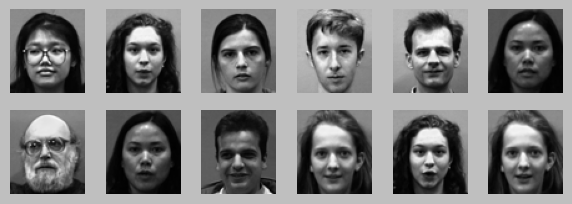

Noisy scaled


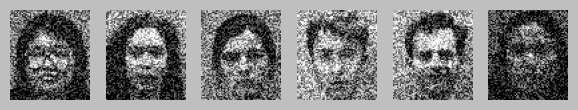

Occlusion v0(0.1)


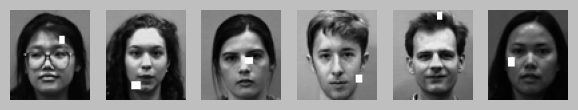

Occlusion v1(0.15)


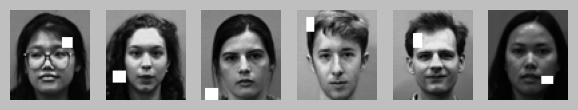

Occlusion v2(0.2)


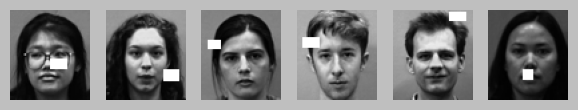

Occlusion v3(0.25)


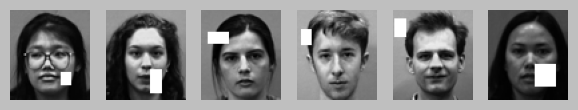

Occlusion v4(0.3)


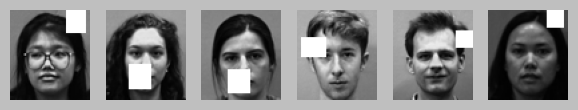

Occlusion v5(0.35)


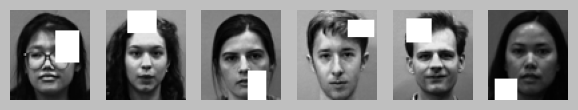

Occlusion v6(0.4)


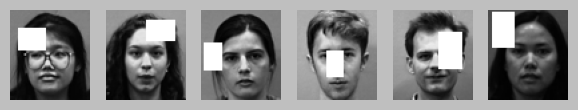

Occlusion v7(0.45)


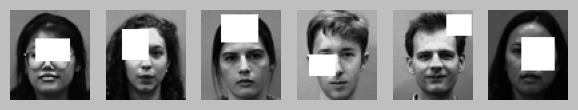

Occlusion v8(0.5)


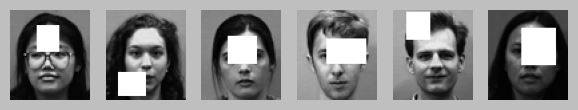

Occlusion v9(0.6)


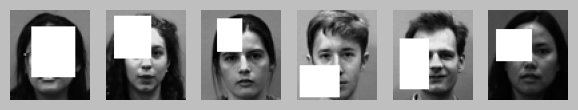

Occlusion v10(0.7)


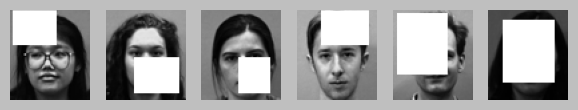

Occlusion v11(0.8)


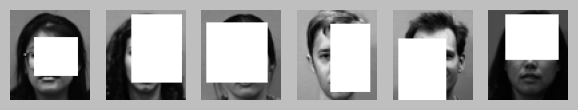

Occlusion v12(0.9)


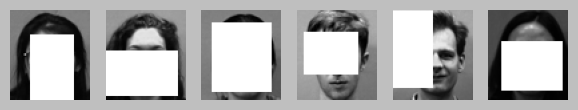

Occlusion v13(1.0)


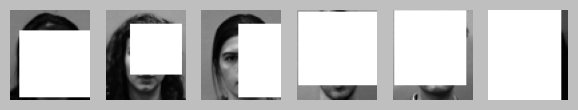

In [6]:
def show_images_in_grid(images, columns=5, max_rows=4, names=None):
    import math
    image_count = len(images)
    col = columns
    row = min(math.ceil(image_count/columns), max_rows)
    plt.style.use("grayscale")
    plt.figure(figsize=(col * 1.2,row * 1.2))
    for i, image_info in enumerate(images):
        if i // col >= row:
            break
        plt.subplot(row, col, i + 1)
        plt.imshow(image_info)
        if names is None:
            plt.title(i)
        else:
            plt.xlabel(f"{i}: {names[i]}-{image_info.shape}")
        plt.axis("off")
    plt.show()
    # plt.close()

display_title("Images")
display_value("image_df.shape", image_df.shape)
display_title(f"Original resized and scaled")
show_images_in_grid(image_df["original_image"].values, columns=6, max_rows=2, names=image_df["filename"])

display_title("Noisy scaled")
show_images_in_grid(image_df["noisy_image"].values, columns=6, max_rows=1, names=image_df["filename"])
for i in range(0, len(OCCLUSION_FACTORS)):
    display_title(f"Occlusion v{i}({OCCLUSION_FACTORS[i]})")
    show_images_in_grid(image_df[f"v{i}"].values, columns=6, max_rows=1, names=image_df["filename"])


## Train, Test and validation sets

In [7]:
value_vars = ["noisy_image"] + [f"v{i}" for i in range(len(OCCLUSION_FACTORS))]
display(value_vars)
df_input = pd.melt(image_df, id_vars=['original_image', 'filename'], value_vars=value_vars, var_name='occlusion', value_name='input_image')
display_value("df_input.shape", df_input.shape)
display(df_input.head())

['noisy_image',
 'v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13']

df_input.shape: (2970, 4)


,original_image,filename,occlusion,input_image
0,"[[[0.49803922], [0.49803922], [0.49411765], [0...",1.png,noisy_image,"[[[0.56078434], [0.64705884], [0.85882354], [0..."
1,"[[[0.59607846], [0.59607846], [0.5921569], [0....",92.png,noisy_image,"[[[0.827451], [0.9098039], [0.8901961], [0.6],..."
2,"[[[0.5372549], [0.5294118], [0.52156866], [0.5...",108.png,noisy_image,"[[[0.2784314], [0.39607844], [0.52156866], [0...."
3,"[[[0.69803923], [0.7019608], [0.6862745], [0.6...",147.png,noisy_image,"[[[0.9019608], [0.8039216], [0.5137255], [0.99..."
4,"[[[0.67058825], [0.6745098], [0.6745098], [0.6...",192.png,noisy_image,"[[[0.34117648], [0.81960785], [1.0], [0.701960..."


In [8]:
# Shuffle de dataset
df_input_shuffled = df_input.sample(frac = 1, replace = False, random_state=101, ignore_index=True)
display(df_input_shuffled.head())

,original_image,filename,occlusion,input_image
0,"[[[0.69411767], [0.69411767], [0.6784314], [0....",32.png,v5,"[[[0.69411767], [0.69411767], [0.6784314], [0...."
1,"[[[0.5019608], [0.50980395], [0.5058824], [0.5...",150.png,v13,"[[[0.5019608], [0.50980395], [0.5058824], [0.5..."
2,"[[[0.36078432], [0.35686275], [0.3529412], [0....",97.png,v3,"[[[0.36078432], [0.35686275], [0.3529412], [0...."
3,"[[[0.69803923], [0.6862745], [0.6784314], [0.6...",186.png,v12,"[[[0.69803923], [0.6862745], [0.6784314], [0.6..."
4,"[[[0.5019608], [0.5137255], [0.5058824], [0.50...",106.png,v4,"[[[0.5019608], [0.5137255], [0.5058824], [0.50..."


Example images


(2970, 4)

0: 32.png
1: 150.png
2: 97.png
3: 186.png
4: 106.png
5: 178.png
6: 114.png
7: 52.png
8: 24.png
9: 2.png


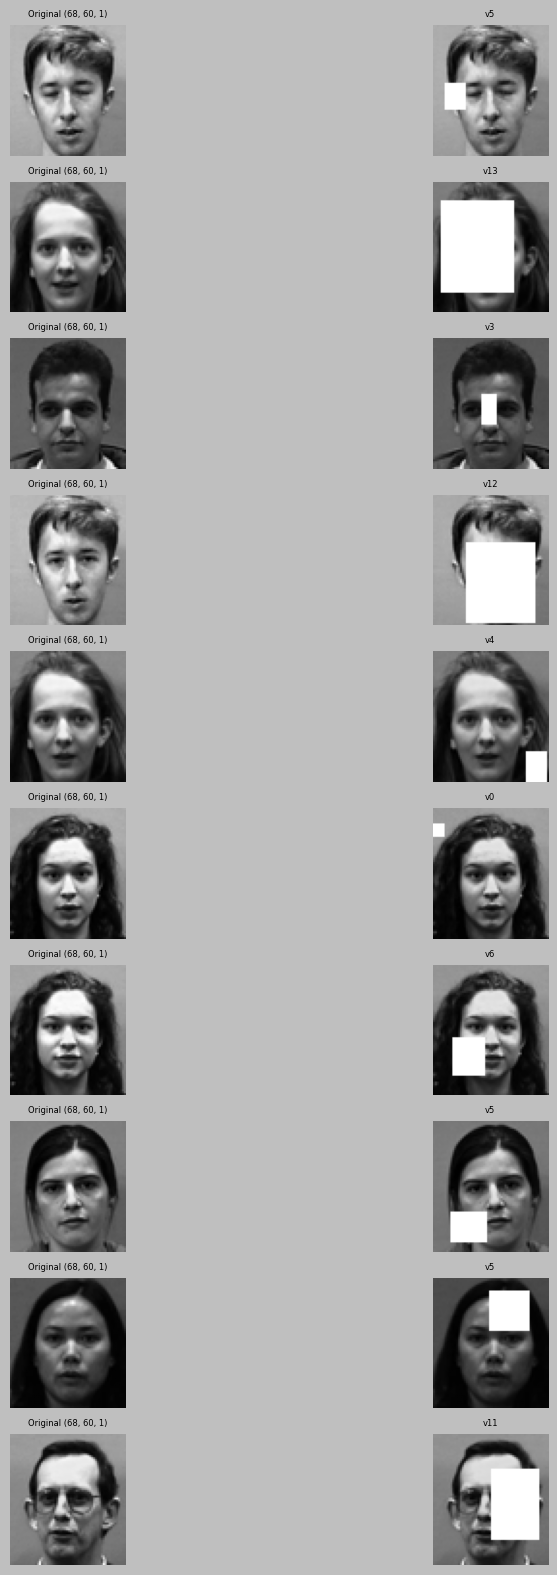

In [9]:
def show_x_and_y(df, max_rows=4, names=None):
    col = 2
    plt.figure(figsize=(max_rows, max_rows*2))
    plt.style.use("grayscale")
    for i, image_record in df.iterrows():
        if i >= max_rows:
            break
        display_value(f"{i}", f"{image_record['filename']}")

        ax1=plt.subplot(max_rows, col, i * 2 + 1)
        plt.imshow(image_record["original_image"])
        ax1.set_title(f"Original {image_record['original_image'].shape}")
        plt.axis("off")

        ax2=plt.subplot(max_rows, col, i * 2 + 2)
        plt.imshow(image_record["input_image"])
        ax2.set_title(f"{image_record['occlusion']}")
        plt.axis("off")

    plt.show()


display_title("Example images")
display(df_input_shuffled.shape)
show_x_and_y(df_input_shuffled, max_rows=10)


In [10]:
# Split in train - test - part 1
X = np.stack(df_input_shuffled["input_image"])
y = np.stack(df_input_shuffled["original_image"])
display(X.shape)
# display(X[1])

(2970, 68, 60, 1)

In [11]:
# Split in train - test - part 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# X_train = np.asarray(X_train).reshape((len(X_train), *RESHAPE_SIZE))
# y_train = np.asarray(y_train).reshape((len(X_train), *RESHAPE_SIZE))
# X_test = np.asarray(X_test).reshape((len(X_train), *RESHAPE_SIZE))
# y_test = np.asarray(y_test).reshape((len(X_train), *RESHAPE_SIZE))
display_value("type(X_train)", type(X_train))
display_value("X_train.shape", X_train.shape)
# display_value("X_train[0]", X_train[0])
display_value("type(X_test)", type(X_test))
display_value("X_test.shape", X_test.shape)


type(X_train): <class 'numpy.ndarray'>
X_train.shape: (2376, 68, 60, 1)
type(X_test): <class 'numpy.ndarray'>
X_test.shape: (594, 68, 60, 1)


## Additional function(s)

### Image display

In [12]:
def show_images(max_rows=5, **image_arrays):
    # Create a figure to display the images
    plt.figure(figsize=(max_rows, max_rows*4))
    # plt.figure(figsize=(15, 10))
    plt.style.use("ggplot")

    columns = len(image_arrays)  # Nbr of columns equals number of names arrays passed
    for i in range(max_rows):
        col = 1
        for k,v in image_arrays.items():
            # Display the first image
            ax_c = plt.subplot(max_rows, columns, i * columns + col)
            plt.imshow(v[i])
            # plt.gray()
            plt.axis("off")
            ax_c.set_title(f"{i}:{k}")
            col = col+1
    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.close()


### Custom Loss function

In [13]:
#### Additional functions

# Additional loss function based on Structural Simularity index
# SSIM is [-1, 1] where 1 is perfect match
def ssim_mean_value(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(img1=y_true, img2=y_pred, max_val=1.0))

# Using the function as a loss function
def ssim_loss(y_true, y_pred):
  return -1 * ssim_mean_value(y_true, y_pred)


### Display History for a trained encoder

In [14]:
# Train and training monitoring
def display_history(history, title="XXXXXXXXXXX"): 
    
    # history_df = pd.DataFrame(history.history)[["loss", "val_loss"]]
    history_df = pd.DataFrame(history.history)
    history_df.plot(
        kind="line",
        figsize=(10, 5),
        xlim=[0, len(history.epoch)+2], grid=True,
        xlabel="Epoch",
        # style=["r--", "g--", "b--", "y--"])
        style={
            "MSE": "r-", "val_MSE": "r--",
            "loss": "b-", "val_loss": "b--",
            "Binary_Crossentropy": "y-", "val_Binary_Crossentropy": "y--",
            "ssim_mean_value": "g-", "val_ssim_mean_value": "g--",
            "accuracy": "c-", "accuracy": "c--",
        }
    )
    plt.legend(loc="upper right")
    plt.title(title)
    plt.show()


### Evaluation function

In [15]:
# Function to calculate base metrics and give a visual
def reconstruction_error_display(image_true, image_input, image_predicted, title="Metrics"):

    def _show_row(index):
        plt.figure(figsize=(4, 16))
        plt.style.use("ggplot")

        r = 4
        c = 3
        ax_mse_min = plt.subplot(4, 3, 1)
        plt.imshow(image_true[index])
        plt.axis("off")
        plt.title("Correct", fontsize=MEDIUM)
    
        ax_mse_min = plt.subplot(4, 3, 2)
        plt.imshow(image_input[index])
        plt.axis("off")
        plt.title("Input", fontsize=MEDIUM)
    
        ax_mse_min = plt.subplot(4, 3, 3)
        plt.imshow(image_predicted[index])
        plt.axis("off")
        plt.title("Reconstruction", fontsize=MEDIUM)

        plt.tight_layout()
        plt.show()
        plt.close()

    display_title(title)

    # Bereken de reconstruction error voor elke predictie

    # MSE
    reconstruction_error_mse = np.mean(np.power(image_true - image_predicted, 2), axis=(1,2))
    display(reconstruction_error_mse.shape)
    min_reconstruction_error_mse_index = np.argmin(reconstruction_error_mse)
    max_reconstruction_error_mse_index = np.argmax(reconstruction_error_mse)
    display_value(f"Laagste MSE: Index[{min_reconstruction_error_mse_index}]", reconstruction_error_mse[min_reconstruction_error_mse_index])
    display_value(f"Laagste MSE: Index[{max_reconstruction_error_mse_index}]", reconstruction_error_mse[max_reconstruction_error_mse_index])

    # SSIM
    display_value("Gemiddelde Structural Simularity index", ssim_mean_value(image_true, image_predicted))

    #
    structural_similarity_index = tf.image.ssim(img1=image_true, img2=image_predicted, max_val=1.0)
    display(structural_similarity_index.shape)
    # xx_numpy = structural_similarity_index.numpy()
    # display(xx_numpy.shape)
    min_structural_similarity_index_index = np.argmin(structural_similarity_index)
    max_structural_similarity_index_index = np.argmax(structural_similarity_index)

    display_value(f"Laagste SSI: Index[{min_structural_similarity_index_index}]", structural_similarity_index[min_structural_similarity_index_index])
    display_value(f"Hoogste SSI: Index[{max_structural_similarity_index_index}]", structural_similarity_index[max_structural_similarity_index_index])

    # Create a figure to display the images
    # Adjust layout
    # plt.close()

    display_title(f"{title}: Minimum MSE")
    _show_row(min_reconstruction_error_mse_index)
    display_title(f"{title}: Maximum MSE")
    _show_row(max_reconstruction_error_mse_index)

    display_title(f"{title}: Minimum SSI")
    _show_row(min_structural_similarity_index_index)
    display_title(f"{title}: Maximum SSI")
    _show_row(max_structural_similarity_index_index)


### Input Summary

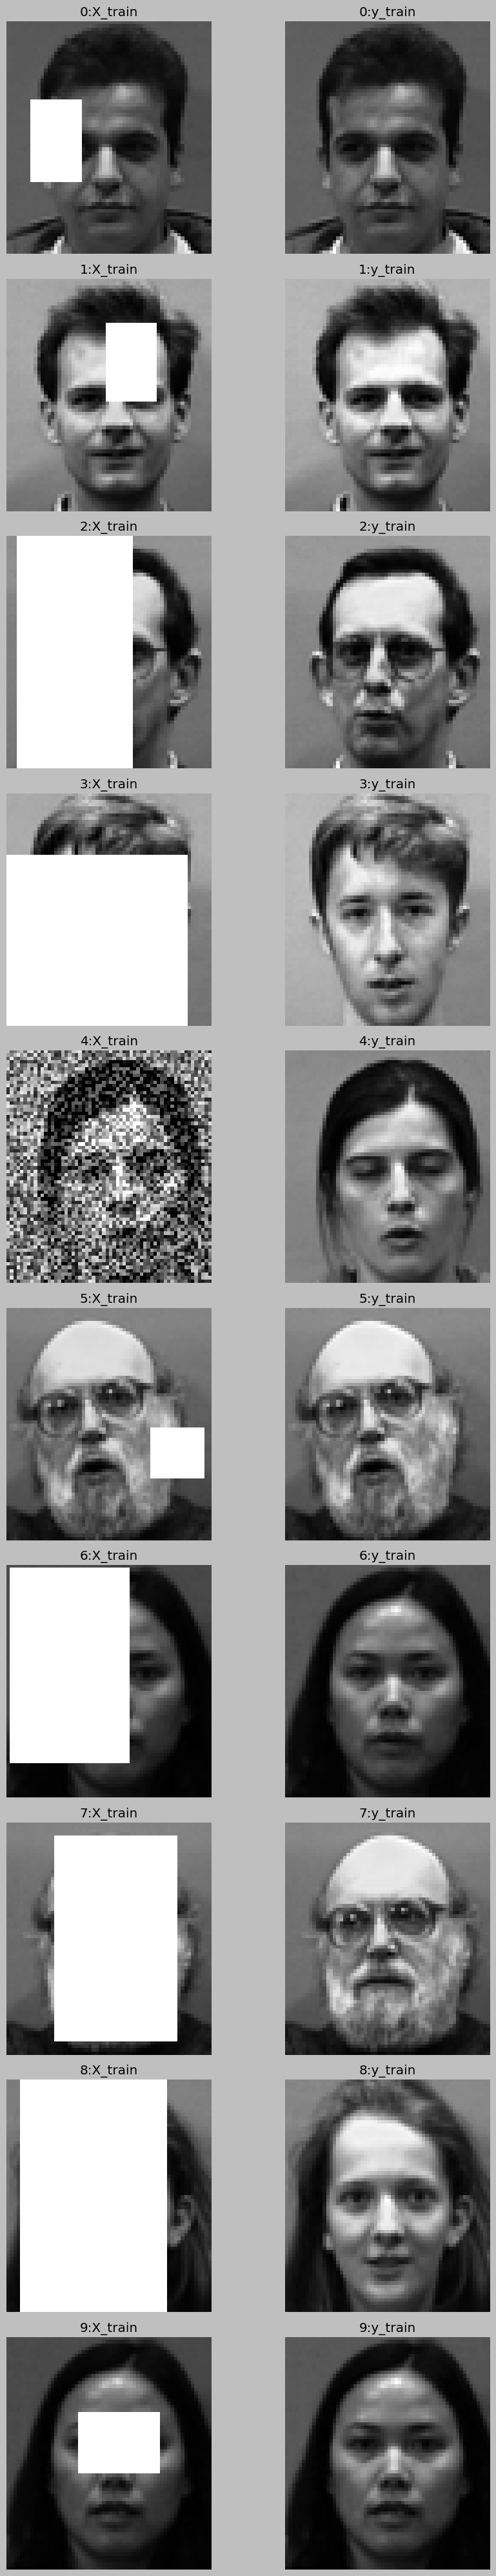

In [16]:
# Show some input (X_train) and expected (y_train)
show_images(max_rows=10, X_train=X_train, y_train=y_train)

## Autoencoder Definitions

### Global Parameters

In [17]:
EPOCHS = 500
BATCH_SIZE = 16

early_stop = EarlyStopping(
    monitor="loss",           # metric to monitor
    patience=3,               # stop when no improvement after 10 consecutive epochs
    mode="min",               # stop when metric stops decreasing
    restore_best_weights=True,
    verbose=True,             # display the actions taken
)

# Reduce learning rate when a metric has stopped improving.
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    mode="min",
    # min_delta=0.0001,
    # cooldown=0,
    min_lr=1e-6,
    verbose=1,             # display the actions taken
)

### Overcomplete AutoEncoder (MSE)

#### Construction

Een eenvoudige overcomplete met slechts 1 layer

In [ ]:
ENCODING_DIM = WIDTH * HEIGHT * 3

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_1 = Model(input_data, decoded)

# Compile
autoencoder_1.compile(
    optimizer='adam',
    loss="mean_squared_error",
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)
display_value("Code layer size", ENCODING_DIM)
autoencoder_1.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_1.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Overcomplete, code layer[{ENCODING_DIM}]")

#### Testing en Evaluation

In [ ]:
# Predict the images from the Training set
predicted_train = autoencoder_1.predict(X_train)

In [ ]:
display_title("Metrics")

reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 1: TRAINING SET")

In [ ]:
# Show examples for training set predictions
display_title("Autoencoder 1: Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

In [ ]:
# Predict the iamges from the test set
predicted_test = autoencoder_1.predict(X_test)

In [ ]:
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 1: TEST SET")

In [ ]:
# Show examples for testing set predictions
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### Overcomplete AutoEncoder (Structural Similarity Index)

#### Construction

Een eenvoudige overcomplete met slechts 1 layer, dezelde structuur als 1

In [ ]:
ENCODING_DIM = WIDTH * HEIGHT * 3

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_2 = Model(input_data, decoded)

# Compile
autoencoder_2.compile(
    optimizer='adam',
    loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)
display_value("Code layer size", ENCODING_DIM)
autoencoder_2.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_2.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Overcomplete, code layer[{ENCODING_DIM}]")


#### Testing en Evaluation

In [ ]:
# Autoencoder 2: Predict the images for the training set
predicted_train = autoencoder_2.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 2: TRAINING SET")
display_title("Autoencoder 2: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)


In [ ]:
# Autoencoder 2: Predict the images for the test set
predicted_test = autoencoder_2.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 2: TEST SET")
display_title("Autoencoder 2: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### --> Overcomplete Autoencoder Conclusies

##### Preprocessing
- het verwerken van image data vraagt serieus wat rekenkracht. Er is gekozen om de originele images te resizen naar iets dat meer bruikbaar is op de voor handen zijnde infrastructuur.
  Dit heeft volgens mij een streke invloed of de accuraatheid van het model in de zin dat er een reele kans bestaat op overfitting.

- Het is spijtig dat de verschillende libraries die toch deel uitmaken van het eco-systeem apis hebben die zo verschillend zijn.

- Ik vermoed dat het toevoegen van een gewone "noisy image" aan de testset een positieve invloed heeft op het reconstructief vermogen van het decoder gedeelte.
  Dit blijkt ook uit de similariry index die oploopt to dicht tegen 1.

##### Train
- Als lossfunctie is the MeanSquaredError en de Simularity Index gebruikt met vergelijkbare resultaten. Inspectie van de grafiek geeft een lichte stijging van de loss-functie voor de validation set, wat eventueel kan wijzen op een overfitting.
- Het trainen van het net vraagt nogal veel resources. Bij een image met shape 90*100 moest ik de GPU kernel telken opnieuw initialiseren (Windes + WSL2). Een adequate hardwareomgeving is zeer belangrijk om onderzoek te kunnen doen naar variaties van models.

- De meeste trials die ik heb geprobeerd is op een image size van (60, 67), dit is original.size/3.
  Bepaalde testen zijn uitgevoerd met (90/100). Het is duidelijk dat dit een beter resultaat geeft, maar verandert niets aan de spirit van de resultaten verkregen met een lagere resolutie.
 
##### Test
- Deze sample is uit de training set gehaald en worden niet gebruikt tijdens training
- De grootte van de testset wordt bepaald door 1 of meerdere keren de frauduleuze transacties te gebruiken (de training set wordt hierdood kleiner)

- Om de classificatie uit te voeren wordt terug gekeken naar de MSE

##### Evaluatie
- Gewoon visueel kunnen we stellen dat de reconstructie vrij gehoorlijk werkt


### Undercomplete AutoEncoder (MSE-1)

#### Construction

Een undercomplete met sterk gereduceerde code layer

In [ ]:
ENCODING_DIM = int((WIDTH * HEIGHT) / 4)

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_3a = Model(input_data, decoded)

# Compile
autoencoder_3a.compile(
    optimizer='adam',
    loss="mean_squared_error",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

display_value("Code layer size", ENCODING_DIM)
autoencoder_3a.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_3a.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Undercomplete, code layer[{ENCODING_DIM}]")

#### Testing en Evaluation

In [ ]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_3a.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 3a: TRAINING SET")
display_title("Autoencoder 3a: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)


In [ ]:
# Autoencoder 3: Predict the images for the test set
predicted_test = autoencoder_3a.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 3a: TEST SET")
display_title("Autoencoder 3a: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### Undercomplete AutoEncoder (MSE-2)

#### Construction

Een undercomplete met sterk gereduceerde code layer

In [ ]:
ENCODING_DIM = int((WIDTH * HEIGHT) / 8)

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_3b = Model(input_data, decoded)

# Compile
autoencoder_3b.compile(
    optimizer='adam',
    loss="mean_squared_error",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

display_value("Code layer size", ENCODING_DIM)
autoencoder_3b.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_3b.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Undercomplete, code layer[{ENCODING_DIM}]")

#### Testing en Evaluation

In [ ]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_3b.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 3b: TRAINING SET")
display_title("Autoencoder 3b: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

# Autoencoder 3: Predict the images for the test set
predicted_test = autoencoder_3b.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 3b: TEST SET")
display_title("Autoencoder 3b: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### Undercomplete AutoEncoder (MSE-3)

#### Construction

Een undercomplete met sterk gereduceerde code layer

In [ ]:
ENCODING_DIM = int((WIDTH * HEIGHT) / 16)

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_3c = Model(input_data, decoded)

# Compile
autoencoder_3c.compile(
    optimizer='adam',
    loss="mean_squared_error",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

display_value("Code layer size", ENCODING_DIM)
autoencoder_3c.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_3c.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Undercomplete, code layer[{ENCODING_DIM}]")

#### Testing en Evaluation

In [ ]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_3c.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 3c: TRAINING SET")
display_title("Autoencoder 3c: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

# Autoencoder 3: Predict the images for the test set
predicted_test = autoencoder_3c.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 3c: TEST SET")
display_title("Autoencoder 3c: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### Undercomplete AutoEncoder (MSE-4)

#### Construction

Een undercomplete met sterk gereduceerde code layer

In [ ]:
ENCODING_DIM = int((WIDTH * HEIGHT) / 32)

input_data = Input(shape=(HEIGHT, WIDTH, 1))
# Flatten the input
encoded = Flatten()(input_data)
# Encoder layer with L1 regularization
encoded = Dense(ENCODING_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(encoded)

# Decoder
decoded = Dense(WIDTH * HEIGHT, activation='sigmoid')(encoded)
decoded = Reshape(target_shape=(HEIGHT, WIDTH, 1))(decoded)

# AE
autoencoder_3d = Model(input_data, decoded)

# Compile
autoencoder_3d.compile(
    optimizer='adam',
    loss="mean_squared_error",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

display_value("Code layer size", ENCODING_DIM)
autoencoder_3d.summary()


#### Training

In [ ]:
# Train and training monitoring
history = autoencoder_3d.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Undercomplete, code layer[{ENCODING_DIM}]")

#### Testing en Evaluation

In [ ]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_3d.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 3d: TRAINING SET")
display_title("Autoencoder 3d: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

# Autoencoder 3: Predict the images for the test set
predicted_test = autoencoder_3d.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 3c: TEST SET")
display_title("Autoencoder 3d: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### --> Undercomplete Autoencoder Conclusies

##### Train
- Het training gaat veel sneller dan bij overcomplete.
- Het aantal epochs nodig is hoger dan bij overcomplete.
 
##### Evaluatie
- Ook hier werkt de reconstructie vrij behoorlijk, zij het dat de resultaten visueel slechter zijn.
- Voor bepaalde use-cases, waar snelheid belangrijker is dan accuraatheid ven de gereconstrueerde beelden, zijn undercomplete AEs duidelijk een optie.


### Convolution AE (Small)

#### Construction


In [18]:
input_data = Input(shape=(HEIGHT, WIDTH, 1))

# Define the encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name="out")(x)

# Define the decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# AE 1
autoencoder_4a = Model(input_data, decoded)

# Compile
autoencoder_4a.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        # keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

autoencoder_4a.summary()

I0000 00:00:1747638667.777536    7191 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1747638667.779553    7191 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3574 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 68, 60, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 68, 60, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 30, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 15, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 15, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (MaxPooling2D)              │ (None, 9, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 18, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 36, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 30, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 68, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 68, 60, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [ ]:
# Train
history = autoencoder_4a.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Convolutional")

#### Testing en Evaluation

In [ ]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_4a.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 4a: TRAINING SET")
display_title("Autoencoder 4a: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

# Autoencoder: Predict the images for the test set
predicted_test = autoencoder_4a.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 3c: TEST SET")
display_title("Autoencoder 4a: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### Convolution AE (Bigger)

#### Construction


In [49]:
input_data = Input(shape=(HEIGHT, WIDTH, 1))

# Define the encoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name="out")(x)

# Define the decoder
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Resizing(HEIGHT, WIDTH)(x)
# AE
autoencoder_4b = Model(input_data, decoded)

# Compile
autoencoder_4b.compile(
    optimizer='adam',
    loss="binary_crossentropy",
    # loss=ssim_loss,
    metrics=[
        ssim_mean_value,
        # keras.metrics.MeanSquaredError(name="MSE"),
        keras.metrics.BinaryCrossentropy(name="Binary_Crossentropy"),
    ],
)

autoencoder_4b.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 68, 60, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 68, 60, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 34, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 34, 30, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 17, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 17, 15, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 6, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 6, 5, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (MaxPooling2D)              │ (None, 3, 3, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 3, 3, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_84 (UpSampling2D) │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 6, 6, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_85 (UpSampling2D) │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 20, 20, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_86 (UpSampling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 42, 42, 128)    │        36,992 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_87 (UpSampling2D) │ (None, 84, 84, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 84, 84, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 68, 60, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,497 (345.69 KB)

 Trainable params: 88,497 (345.69 KB)

 Non-trainable params: 0 (0.00 B)

#### Training

Epoch 1/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - Binary_Crossentropy: 0.6488 - loss: 0.6488 - ssim_mean_value: 0.2194 - val_Binary_Crossentropy: 0.5961 - val_loss: 0.5961 - val_ssim_mean_value: 0.3736
Epoch 2/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Binary_Crossentropy: 0.5924 - loss: 0.5924 - ssim_mean_value: 0.3868 - val_Binary_Crossentropy: 0.5829 - val_loss: 0.5829 - val_ssim_mean_value: 0.4416
Epoch 3/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Binary_Crossentropy: 0.5788 - loss: 0.5788 - ssim_mean_value: 0.4568 - val_Binary_Crossentropy: 0.5759 - val_loss: 0.5759 - val_ssim_mean_value: 0.4931
Epoch 4/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Binary_Crossentropy: 0.5729 - loss: 0.5729 - ssim_mean_value: 0.5013 - val_Binary_Crossentropy: 0.5692 - val_loss: 0.5692 - val_ssim_mean_value: 0.5383
Epoch 5/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Binary_Crossentropy: 0.5662 - loss: 0.5662 - ssim_mean_value: 0.5461 - val_Binary_Crossentropy: 0.5671 - val_lo

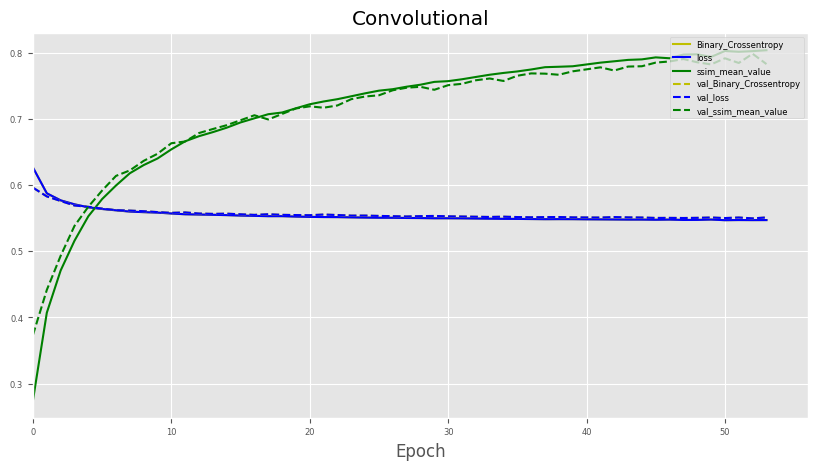

In [50]:
# Train
history = autoencoder_4b.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True,
    validation_split=0.3,
    verbose=1,
)

display_history(history, title=f"Convolutional")

#### Testing en Evaluation

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Autoencoder 4b: TRAINING SET


(2376, 1)

Laagste MSE: Index[1231]: [0.00051444]
Laagste MSE: Index[1362]: [0.03638427]
Gemiddelde Structural Simularity index: 0.8006396293640137


TensorShape([2376])

Laagste SSI: Index[2253]: 0.29020968079566956
Hoogste SSI: Index[688]: 0.9384161233901978
Autoencoder 4b: TRAINING SET: Minimum MSE


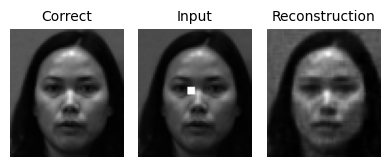

Autoencoder 4b: TRAINING SET: Maximum MSE


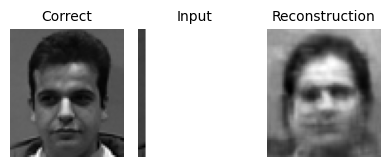

Autoencoder 4b: TRAINING SET: Minimum SSI


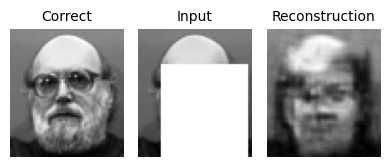

Autoencoder 4b: TRAINING SET: Maximum SSI


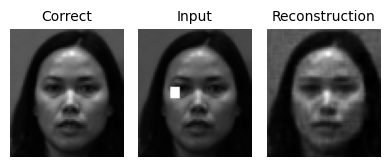

Autoencoder 4b: : TRAIN Visual inspection


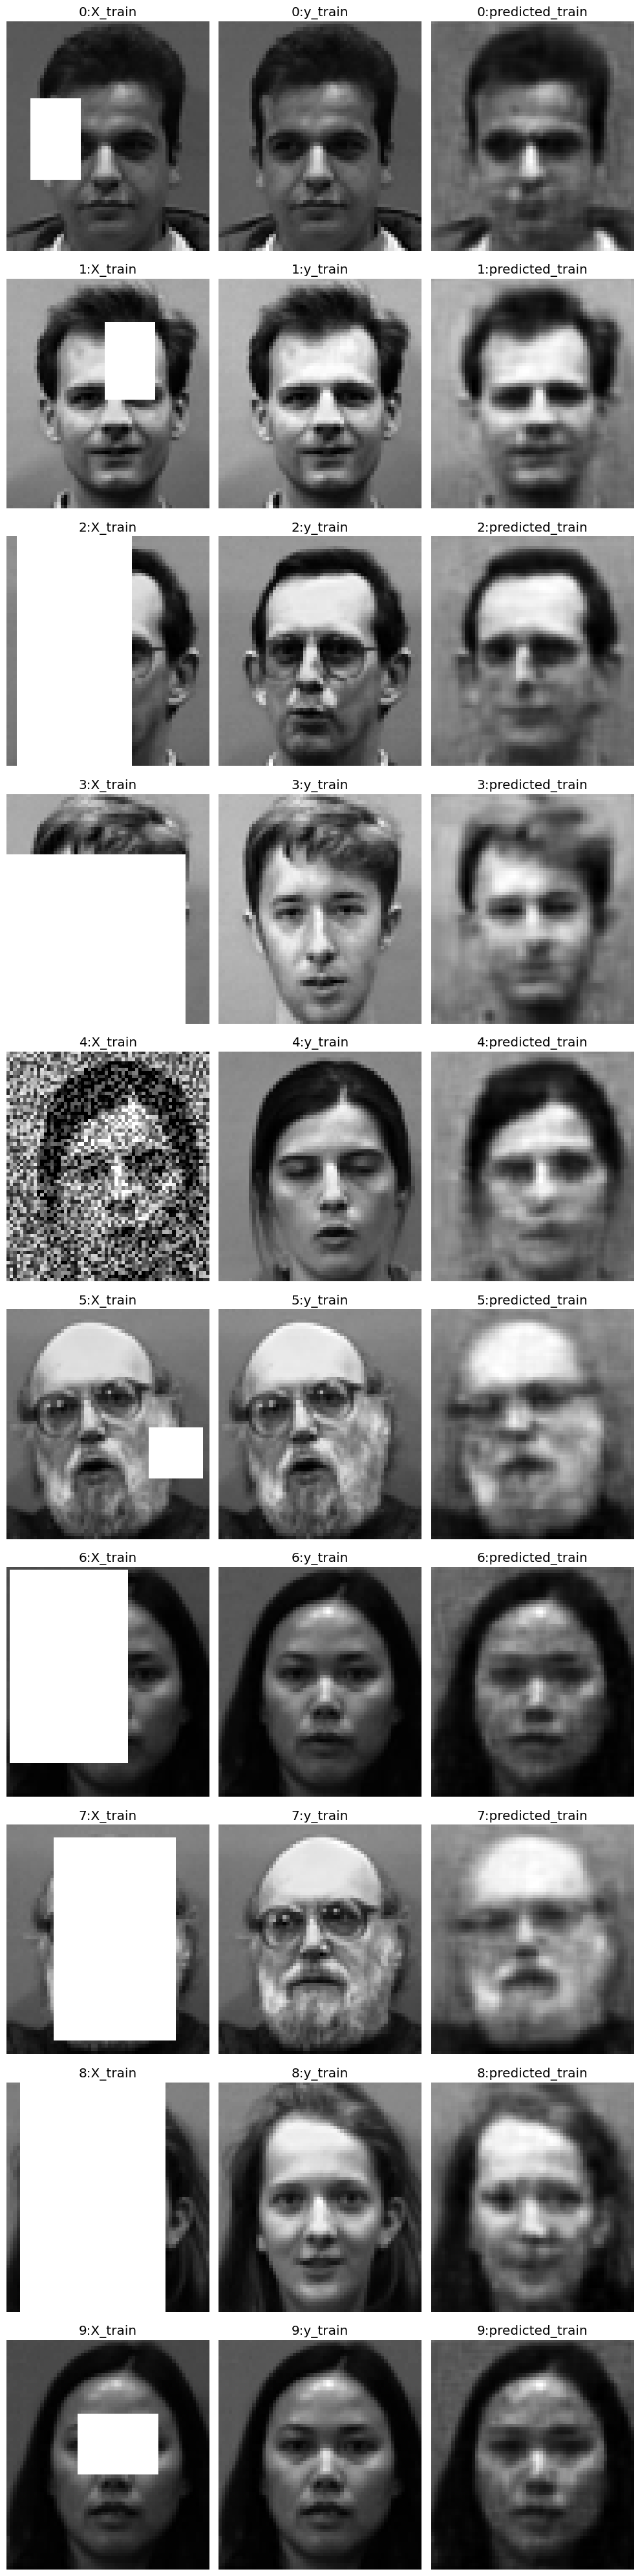

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Autoencoder 4b: TEST SET


(594, 1)

Laagste MSE: Index[367]: [0.00055343]
Laagste MSE: Index[574]: [0.04034233]
Gemiddelde Structural Simularity index: 0.7847211956977844


TensorShape([594])

Laagste SSI: Index[359]: 0.28833240270614624
Hoogste SSI: Index[367]: 0.9351865649223328
Autoencoder 4b: TEST SET: Minimum MSE


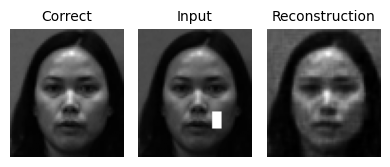

Autoencoder 4b: TEST SET: Maximum MSE


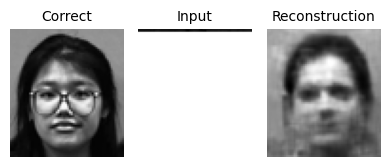

Autoencoder 4b: TEST SET: Minimum SSI


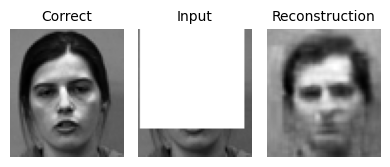

Autoencoder 4b: TEST SET: Maximum SSI


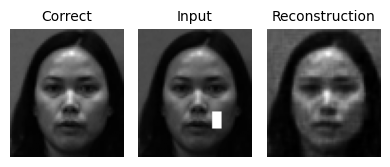

Autoencoder 4b: : TEST Visual inspection


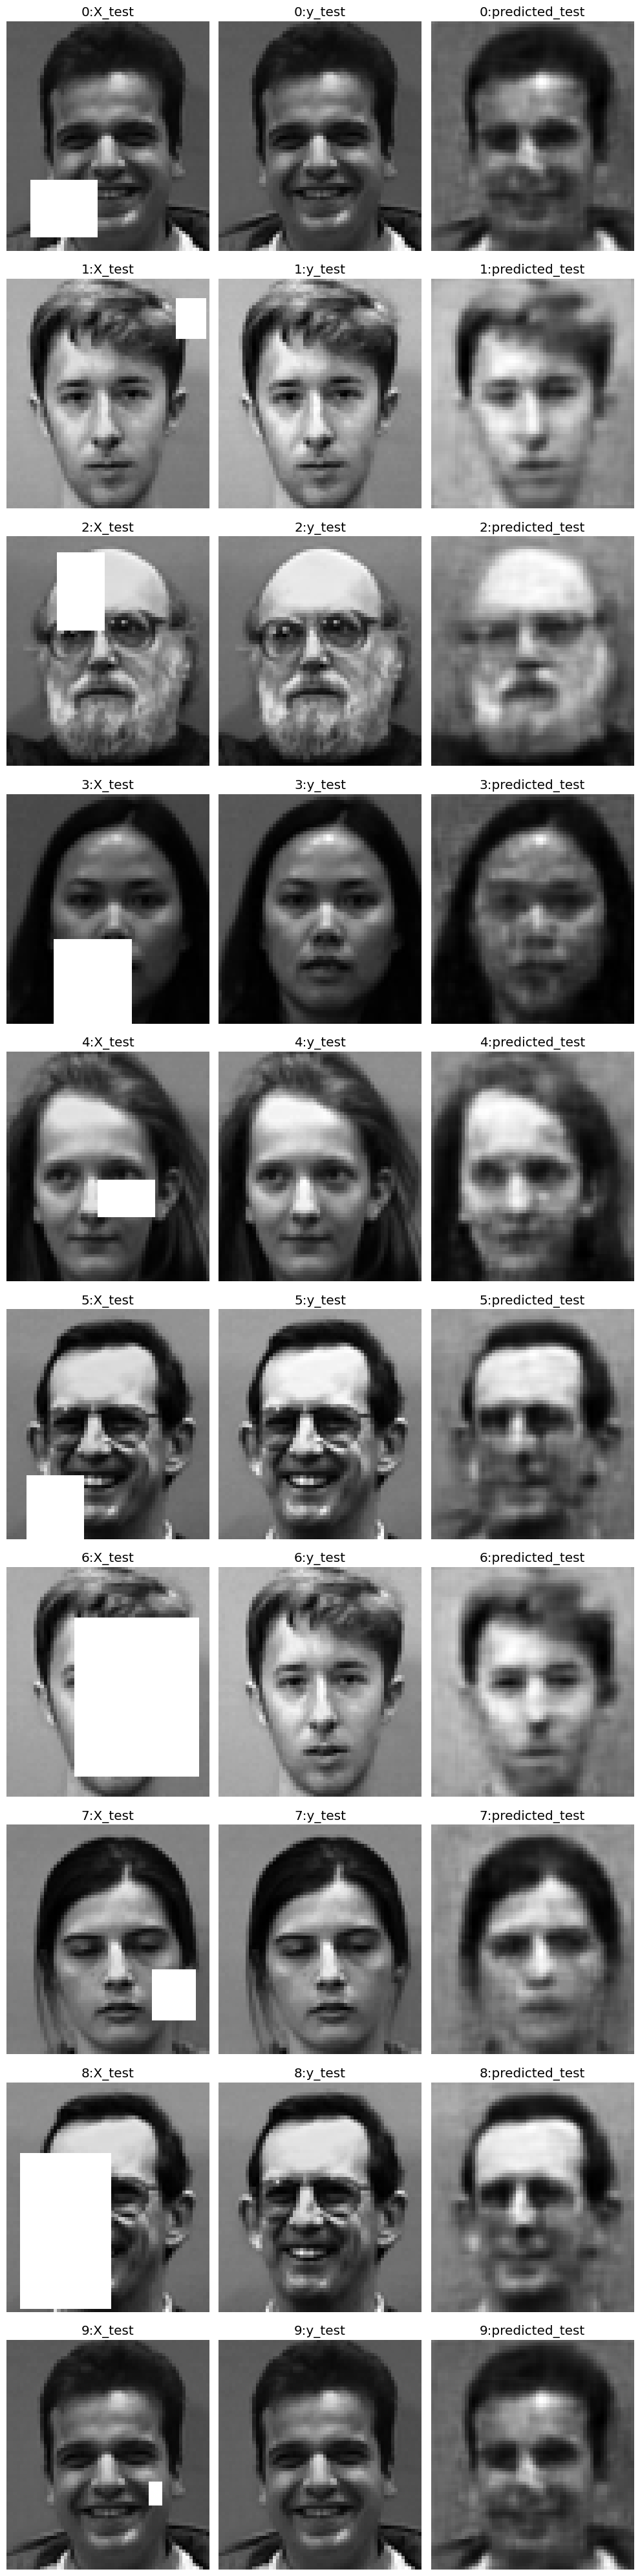

In [51]:
# Autoencoder: Predict the images for the training set
predicted_train = autoencoder_4b.predict(X_train)
reconstruction_error_display(y_train, X_train, predicted_train, "Autoencoder 4b: TRAINING SET")
display_title("Autoencoder 4b: : TRAIN Visual inspection")
show_images(max_rows=10, X_train=X_train, y_train=y_train, predicted_train=predicted_train)

# Autoencoder: Predict the images for the test set
predicted_test = autoencoder_4b.predict(X_test)
reconstruction_error_display(y_test, X_test, predicted_test, "Autoencoder 4b: TEST SET")
display_title("Autoencoder 4b: : TEST Visual inspection")
show_images(max_rows=10, X_test=X_test, y_test=y_test, predicted_test=predicted_test)

### --> Convolutional Autoencoder Conclusies

##### Train
- Het model moet aangepast worden om de scaling van de images te respecteren bij het terug upscalen van de beelden. 
 
##### Evaluatie
- De reconstructie werkt duidelijk slechter dan bij een standaard AE.


## 3. Image segmentation

Autoencoders kunnen ook getraind worden om image segmentation uit te voeren. Segmentatie betekent dat je specifieke objecten in de afbeelding gaat afzonderen van de rest van de afbeelding. In de praktijk komt dit meestal neer op het inkleuren het desbetreffende object in de afbeelding. Image segmentation vindt onderandere zijn toepassing bij self-driving cars, video surveillance en medical imaging. Bij deze opdracht is het de bedoeling om longen te segmenteren uit X-ray afbeeldingen.

Foto's van de longen zijn te vinden in de map Lung_images. 

De labels zijn in dit geval mask afbeeldingen die de exacte locatie van de longen aanduiden. Deze masks bevinden zich in de map Lung_masks.

Ga bij deze opdracht als volgt te werk:

- Lees de afbeeldingen in en schaal deze allemaal naar dezelfde grootte. Bijvoorbeeld naar 400x400 pixels. Lagere resolutie mag ook als je merkt dat de systeemvereisten niet volstaan. Voor deze toepassing mag alles naar grijswaarden worden omgezet.

- Maak een training set en test set aan. Stop een 20-tal afbeeldingen in de test set.

- Train een convolutional autoencoder op de training set. De output layer moet dezelfde dimensie hebben als de mask images. De autoencoder wordt namelijk getraind om op basis van een long-scan een mask te genereren die zo goed mogelijk de ground truth mask benadert. Dit vereist echter een aangepaste loss functie om de autoencoder mee te trainen. Cross-entropy gebaseerde loss functies zijn hiervoor niet altijd geschikt. In de praktijk wordt dikwijls de dice coefficient loss gebruikt. Deze kijkt naar de overlap tussen twee data samples. In dit geval hoeveel de door de autoencoder gegeneerde mask overlapt met de ground truth mask. Deze dice loss moet je zelf als custom loss meegeven met het neuraal netwerk.

```Python
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

```   

- Test de autoencoder op de afbeeldingen uit de test set. Visualiseer de gegeneerde mask en vergelijk met de werkelijke mask. Probeer de segmentatie te verbeteren via hyperparameter tuning. Gebruik hiervoor naast visuele inspectie ook de dice coefficient als metric.

- U-net is een veelgebruikt neuraal netwerk voor medical image segmentation. Een voorbeeld hiervan kan je vinden op https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277. Implementeer, train en test dit netwerk. Gebruik ook eens de dice coefficient loss als custom loss functie. Bespreek de resultaten.
   

In [ ]:
# Dice coefficient loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
# Uitwerking image segmentation
